<a href="https://colab.research.google.com/github/janchorowski/ml_uwr/blob/fall2020/lectures/10_neuralnets_kernels_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning @ UWr 2021

**Lecture 10**

During the last lecture we have seen how XGBoost builds ensembles of trees. The final model implemented the following formula:

$$
F_T(x) = \sum_{t=1}^T f_t(x)
$$

where $f_t$ are trees that map samples $x$ to values stored in the tree leaves. 

The model can be interpreted as performing two operations:
1. $x$ is nonlinearly transformed into a vector of 0/1 indicator variables, each denoting the presence or absence of $x$ i a given tree leaf.
2. The indicator variables are linearly transformed to produce the model output.



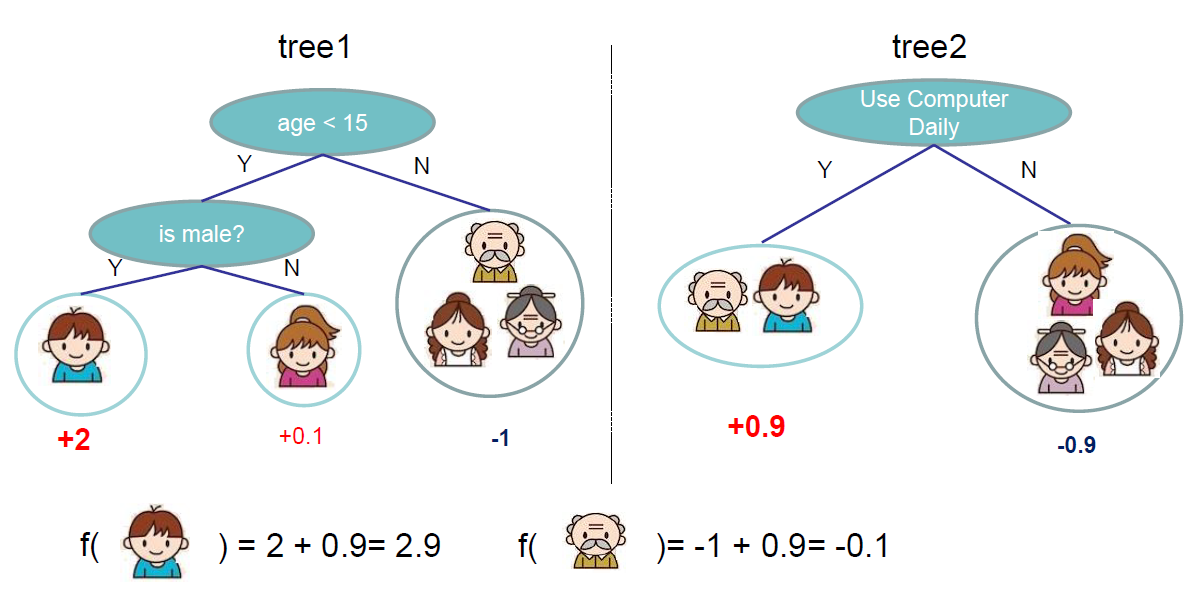

[From T.Q Chen's XGBoost presentation]

Under this interpretation, XGBoost learns a representation of samples in which linear models work well. 

We have already seen one other model that relied on linear combination of features extracted from data: the polynomial regression. Again, it processed samples in two steps:
1. map an $x\in\mathbb{R}$ to a vector of its powers: $x \rightarrow [1, x, x^2, x^3, ...]$.
2. linearly combine the powers of $x$ (the extracted features).

In this lecture we will explore two other ways of feature extraction:
1. Neural networks learn a series of non-linear data transformations, followed by a prediction layer (e.g. SoftMax).
2. Kernel methods apply a fixed data transformations that expand its dimensionality to such a degree, that linear models work well.

Finally, we will introduce a model that works great with kernel-based feature expansion: the Support Vector Machine (SVM). SVMs will also expose us to the concept of Maximal Margins, a notion of model complexity which has been also used to explain the generalization performance of boosting.

Please note, that dut to course length constraints this set of lecture notes is presented at a very intuitive level. We apologize for this lack of depth and direct the curious reader to textbooks, such as Bishop, or lecture notes from e.g. [CS229](http://cs229.stanford.edu/).

## Intuitions about Neural Networks and Deep Learning

We will show here a very simple neural network. If you would want to learn more, please enroll into my course ["Neural Networks and Deep Learning"](https://github.com/janchorowski/dl_uwr).

Please recall the logistic regression classifier. It takes a sample $x\in \mathbb{R}^D$ and classifies it by checing the sign of $x\Theta + b$, which can be interpreted as separating the two classes with a line determined by the vector $\Theta$:

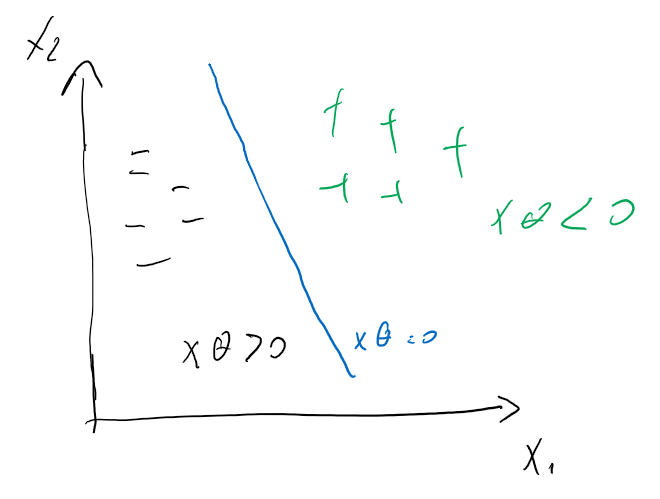

Logistic Regression is a nice, simple, and undertandable model. However, it has limited capacity to fit the training data. For instance, it can't solve the XOR problem:

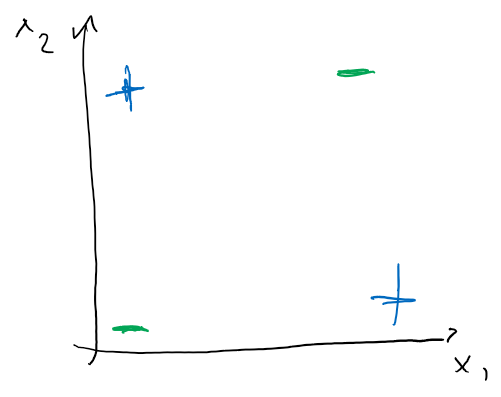

Let's write down the XOR dataset:

$x_1$ | $x_2$ | $y$
:----:|:-----:|:---:
0 | 0 | 0 
0 | 1 | 1
1 | 0 | 1
1 | 1 | 0

Suppose we apply to $x$ a feature transformation:
$$
[x_1, x_2] \rightarrow [x_1 \text{ OR } x_2, x_1 \text{ AND } x_2]
$$
The transformed data is linearly separable:

$x_1$ | $x_2$ | $x_1$ OR $x_2$ | $x_1$ AND $x_2$ | $y$
:----:|:-----:|:--------------:|:----------------:|:---:
0 | 0 | 0 | 0 | 0 
0 | 1 | 1 | 0 | 1
1 | 0 | 1 | 0 | 1
1 | 1 | 1 | 1 | 0


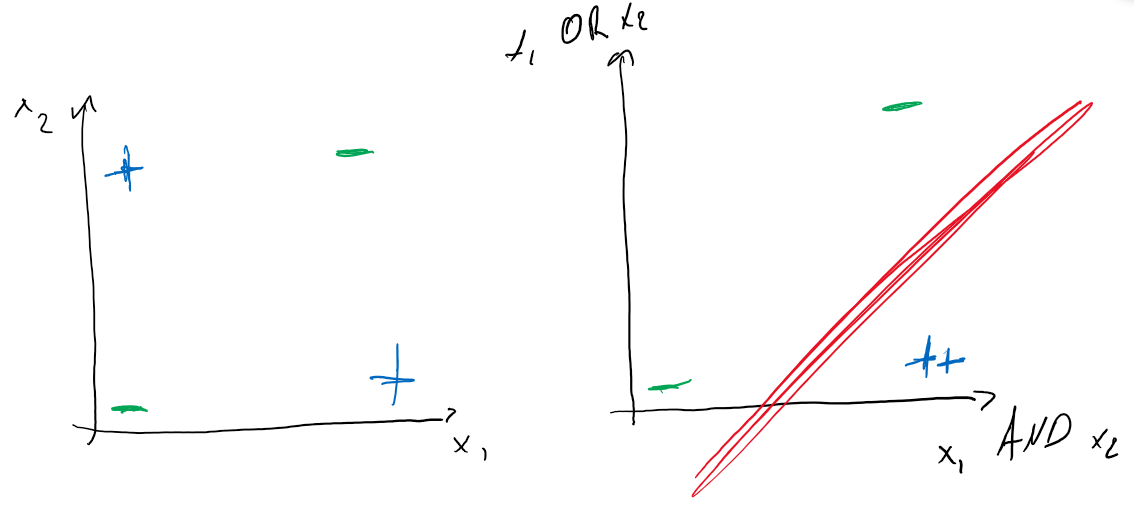

Observation: AND and OR functions can be computed by:
- linearly projecting the data
- applying a nonlinearity (e.g. a threshold operation)

$$
x \text{ OR } y = [x + y > 0.5] \\
x \text{ AND } y = [x + y > 1.5]
$$
where $[]$ is the indicator function.

Thus, our XOR model could work as follows:
- linealry project the data
- apply nonlinearities
- linearly separate the two classes

We could present this model graphically like that:

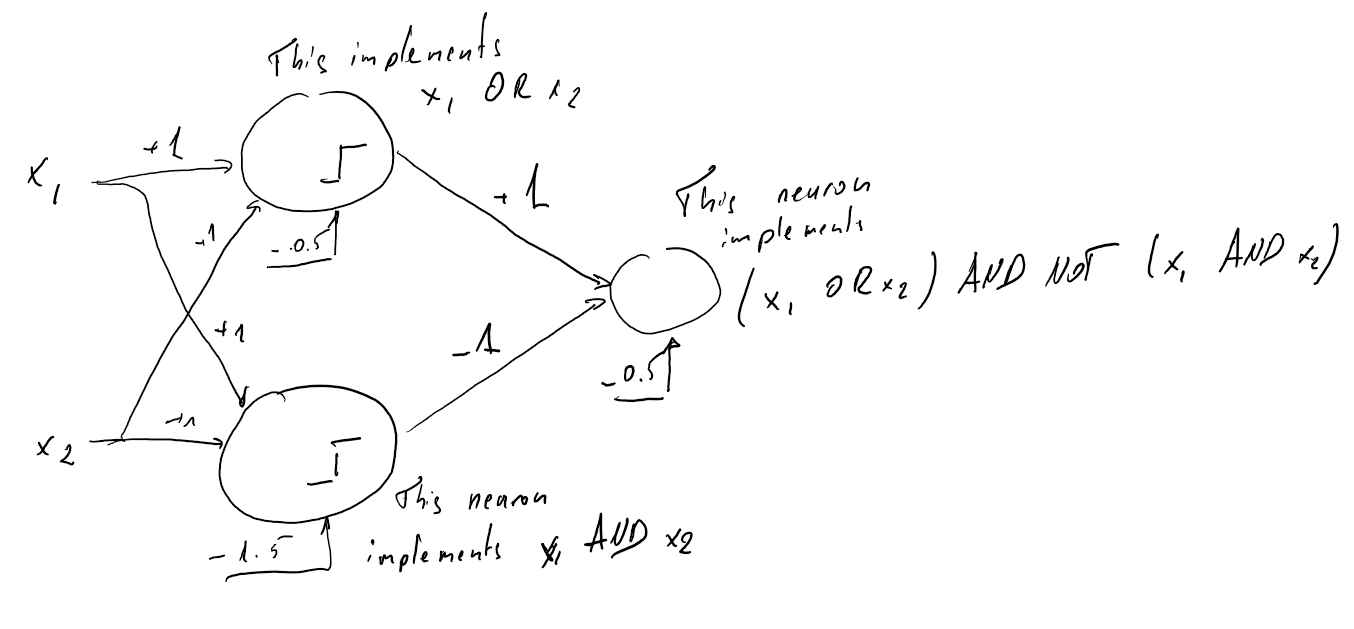

We call such model an _artificial neural network_. Artificial neurons are simple computing units which take a linear combination of their inputs and apply a nonlinear transformation (a so called activation function). A network of neurons is called, a neural network.

## Training of neural networks

The neural network presented above has one drawback: it can't be trained! We have invented its parameters (weights and biases), however we have no simple procedure of fitting them to the data (genetic or evolutionary algorithms, shold work for simple networks, but gradient-based methods work better for large ones). This limitation has a very simple reason:
our activation functions are non-differentiable!

We will make one small change to our network and replace the hard threshold activation function with a smooth approximation, such as the logistic sigmoid. This change makes the neural network amenable to gradient-based optimization. using it we can fit all parameters (the weights in the feature transformation and in the output combination) jointly to optimize a loss function. The network simultaneously discovers features and the separating hyperplane!

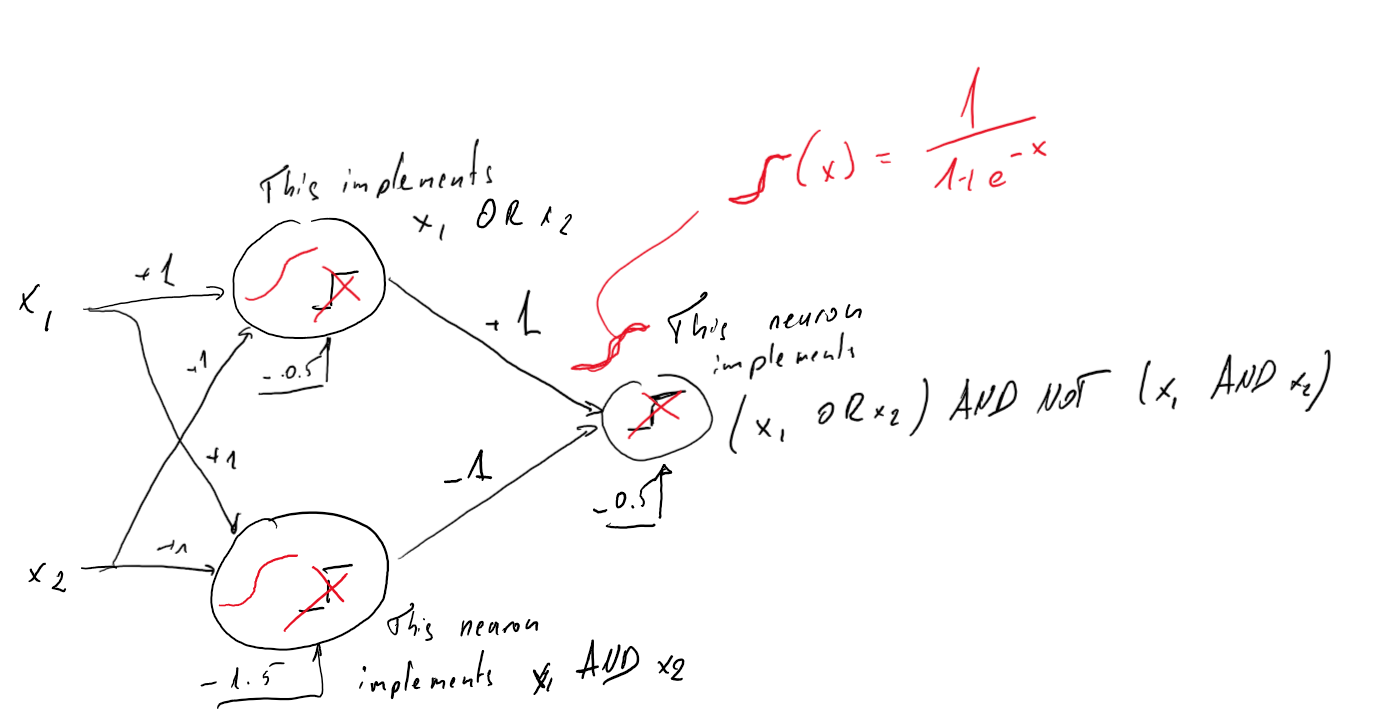

### Neural network demonstration

We will now perofrm a small demonstration of the XOR network

In [1]:
import torch
import torch.nn.functional as F
torch.manual_seed(42)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = torch.tensor(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1]], dtype=torch.float)

Y = torch.tensor(
    [[0], [1], [1], [0]], dtype=torch.float)

# Weights and biases of the learnable feature extractor
NUM_NEURONS = 2
Wf = torch.zeros(X.shape[1], NUM_NEURONS, requires_grad=True)
bf = torch.zeros(NUM_NEURONS, requires_grad=True)

# Weight and bias of the output projection
Wo = torch.zeros(NUM_NEURONS, 1, requires_grad=True)
bo = torch.zeros(1, requires_grad=True)

params = [Wf, bf, Wo, bo]

# Randomly initialize the weight matric
with torch.no_grad():
    Wf[...] = torch.randn(*Wf.shape)
    Wo[...] = torch.randn(*Wo.shape)

# Do a few gradient descent steps
alpha = 1
for step in range(2000):
    features = torch.sigmoid(X @ Wf + bf)
    output = features @ Wo + bo
    loss = F.binary_cross_entropy_with_logits(output, Y)
    if (step % 200) == 0:
        print(
            f"step: {step}, loss: {loss.item()} "
            f"acc: {((output>0) == Y).float().mean().item()}")
    loss.backward()
    
    with torch.no_grad():
        for p in params:
            p -= alpha * p.grad
            p.grad.zero_()

step: 0, loss: 0.7612034678459167 acc: 0.5
step: 200, loss: 0.6931622624397278 acc: 0.5
step: 400, loss: 0.6931366920471191 acc: 0.5
step: 600, loss: 0.6931180953979492 acc: 0.5
step: 800, loss: 0.6930738091468811 acc: 0.5
step: 1000, loss: 0.6928442120552063 acc: 0.75
step: 1200, loss: 0.6866856813430786 acc: 0.75
step: 1400, loss: 0.4582027196884155 acc: 0.75
step: 1600, loss: 0.07428639382123947 acc: 1.0
step: 1800, loss: 0.03142259642481804 acc: 1.0


In [3]:
print(f"Wf={Wf.detach()}")
print(f"bf={bf.detach()}")

print(f"Wo={Wo.detach()}")
print(f"bo={bo.detach()}")

Wf=tensor([[4.4945, 6.4126],
        [4.4946, 6.4129]])
bf=tensor([-6.8840, -2.8155])
Wo=tensor([[-10.1550],
        [  9.4216]])
bo=tensor([-4.2937])


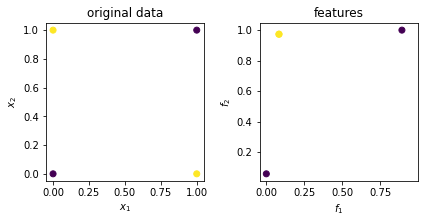

In [4]:
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.axis('square')
plt.title('original data')
plt.xlabel('$x_1$'), plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plt.scatter(features[:,0].detach(), features[:,1].detach(), c=Y[:,0])
plt.axis('square')
plt.title('features')
plt.xlabel('$f_1$'), plt.ylabel('$f_2$')

plt.tight_layout()

Please note how the two feature extracting neurons (which are typicalli calle dthe hidden neurons) have learned to approximate the _and_ and _or_ logic functions. Thus the network has learned, all by itself, a useful data transformation! This observation is the cornerstone of modern deep learning methods. While they employ models which are more sophisticated than the simple network above, they allso implement models which gradually, layer-by-layer, transform data from its raw form (e.g. raw image pixels) into features in which a simple SoftMax classifier can work. The whole model is tuned using gradient descent and useful data representations are discovered by the model.

## Kernel-based Feature expansion

We will now learn about another way to expand the data, this time using fixed, but highly (possibly infinitely) dimensional data transformations. We will start with a simple observation.
Let's look at a gradient descent update for linear regression:
$$
\Theta := \Theta + \alpha\cdot \sum_{i=1}^n \left( y^i - \Theta^T \cdot x^i \right) \cdot x^i.
$$

Which leads to the following conclusion:
> The gradient of the loss on an example $x$ with respect to the parameters of linear or logistic regression is a scaled $x$.

In fact, you may recall that for linear regression the gradient was
$$
\frac{\partial L(\Theta)}{\partial \Theta} = X^T\left(X\Theta-Y\right) = \sum_i (X^i)^Tc^i
$$ 
where $c$ are constants. 
Similarly, for logistic regression the gradient is:
$$
\frac{\partial L(\Theta)}{\partial \Theta} = X^T\left(\sigma(X\Theta)-Y\right) = \sum_i (X^i)^Tc'^i
$$
where again $c'$ are constants.

If we start the gradient descent from a zero vector, the vector $\theta$ will always be a linear combination of training samples! Thus we can write the trained $\Theta$ as:
$$
\Theta = \sum_i\alpha^i (x^i)^T.
$$

This is a powerful observation: for many models, including linear and logistic regression, we can forget about $\Theta$ and instead wotk with the sample weigths $\alpha$. This may be beneficial for instance, if we have more dimensions that data samples.

Using the $\alpha$ form of the model has important implications on the way in which we are accessing the data. Consider first the application of a model to a new data sample:
$$
x\theta = x\left(\sum_i\alpha^i (x^i)^T\right) = \sum_i\alpha^i \left(x(x^i)^T\right) = \sum_i\alpha^i <x, x^i>,
$$
where $<u, v> = u v^T$ denotes the dot-product between the row vectors $u$ and $v$.

The above equation means, that when using the $\alpha$ parameterization of the model, we access data only through dot-products with other data samples.

This allows the use of kernel functions $K$. Intuitively, a kernel function is a smart way of computing dot-products of non-linearly transformed data. That is:
$$
K(u, v) = \phi(u) (\phi(v))^T = <\phi(u), \phi(v)>
$$
In other words, for a matched pair of a kernel function $K$ and a feature exansion function $\phi$ we have two ways of computing the dot-products on transformed data:
1. Apply the kernel function to raw data
2. Transform the data using $\phi$, then compute the dot-products.

If $phi$ projects the data into a highly-dimensional space, the kernel function approach may be significantly faster.





Let's see a motivating example.

Consider 1-dimensional data samples $u\in\mathbb{R}$ and $v\in\mathbb{R}$ and let $K(u, v) = (uv + 1)^3$.

Let's expand it to:
$$
\begin{split}
K(u, v) &= (uv + 1)^3 \\
&= 1 + 3uv + 3(uv)^2 + uv \\
&= 1\cdot 1 + \sqrt{3}u\cdot \sqrt{3}v + \sqrt{3}u^2\cdot \sqrt{3}v^2 + u^3\cdot v^3\\
&= \left[1, \sqrt{3}u, \sqrt{3}u^2, u^3 \right] \cdot \left[1, \sqrt{3}v, \sqrt{3}v^2, v^3 \right]^T \\
&= \phi(u) (\phi(v))^T,
\end{split}
$$
where $\phi(x) = [1, \sqrt{3}x, \sqrt{3}x^2, x^3]$.

In this example, the kernel function corresponds to a polynomial feature expansion (up to the $\sqrt{3}$ scaling constants). However, the kernel may be faster to compute.

Now consider that the data are two dimensional: $u=[u_1, u_2]$ and $v=[v_1, v_2]$. Again let $K(u, v) = (uv^T + 1)^2$ and expand:

$$
\begin{split}
K(u, v) &= (uv^T + 1)^2 = (u_1v_1 + u_2v_2 + 1)^2 \\
&= 1 + 2u_1v_1 + 2u_2v_2 + 2u_1v_1u_2v_2 + (u_1v_1)^2 + (u_2v_2)^2 \\
&= \left[1, \sqrt{2}u_1, \sqrt{2}u_2, \sqrt{2}u_1u_2, u_1^2, u_2^2 \right] \cdot \left[1, \sqrt{2}v_1, \sqrt{2}v_2, \sqrt{2}v_1v_2, v_1^2, v_2^2 \right]^T \\
&= \phi(u) (\phi(v))^T.
\end{split}
$$

Again, the kernel function induces a corresponding feature expansion. This time, the space savings are more apparent: we can compute the kernel using 3 multilications and 2 additions, while the dot-product in the expanded space costs us 5 multiplications and 5 additions, to which we must add the cost of the polynomial feature expansion. Needless to say, the computational savings grow when the data is more dimensional  and when we use a higher power in the kernel function.

The example has introduced us to the first general purpose kernel function, called the polynomial kernel $K_P$:

$$
K_p(u, v) = (uv^t + c)^d,
$$
where u,v are row-vectors, $d$ is the poynomial degree, and $c$ controls the relative influence of the low and high degree components. 

The use of the kernel function enforces the $\alpha$ formulation of the model. We never apply the feature expansions directly, and we thus never store nor directly learn the parameters $\theta$. Instead, we introduce the variables $\alpha^i$ and we optimize our loss function with respect to them. This has an important consequence: the size of our model (the number of $\alpha^i$s that we must store) grows with the dataset size! This is often beneficial anyway, because the dimensionality of the space into which $\phi$ places the data can grow very fast (consider a dataset with 100 raw features and the polynomialkernel with d=10)!

### Other popular Kernel Functions

The dot-product of two samplest measures how similar they are - it is larges if the two samples are the same up to scaling. Thus, intuitively, kernel functions should also capture some notion of sample similarity.

A case in point is the Gaussian Kernel defined as

$$
K_G(u,v) = e^{\frac{-||u-v||^2}{2\sigma^2}},
$$
where $\sigma$ is a parameter.

The Gaussian Kernel is large if the $u$ and $v$ samples are identical, then it rolls off to zero, with the speed of decrease controlled by the $\sigma$ parameter. 

The Gaussian Kernel intuitively leads to a nearest-neighbors behavior of the model: the samples which are near the query have large kernel values and hence the largest influence on the model's output.

For many domains, specialised kernel functions exist. Consider a text dataset, and define the kernel to be the number of common substrings. On the one hand, this corresponds to a feature expansions in which each feature denotes the presence of a given string over the alphabet. On the other hand, common substrings can be efficiently computed using many dynamic programming algorithms.

### Conditions for Valid Kernels

The remaining question is which functions are valid Kernel functions, that is which functions induce an expanded feature space with a dot-product equal to the kernel function application?

The answer is provided by the [Mercer's theorem](https://en.wikipedia.org/wiki/Mercer%27s_theorem): let $K$ be a symmetrical function on pairs of vectors, that is $K(u,v) = K(v,u)$. Then $K$ is a valid kernel function if and only if 

$$
\sum_{i=1}^N\sum_{j=1}^NK(x^i, x^j)c_i c_j \geq 0
$$

for all finite sequence of vectors $x^1,..., x^N$ and real numbers $c_1,...,c_n$.

In other words, the matrix obtained by applying the kernel to any dataset must be symmetric and positive semi-definite.

Intuitively, this reflects the properties of the dot-product. We will now only show that the Mercer condition is required for K to be a kernel. Suppose that K indices a transformation $\phi$. Then:
$$
\sum_{i=1}^N\sum_{j=1}^NK(x^i, x^j)c_i c_j  = \sum_{i=1}^N\sum_{j=1}^N\phi(x^i)\phi(x^j)^Tc_i c_j = \left(\sum_{i=1}^N c_i \phi(x^i)\right)\left(\sum_{j=1}^N c_j \phi(x^j)\right)^T = \left\|\left(\sum_{i=1}^N c_i \phi(x^i)\right)\right\|^2 \geq 0.
$$
